### Thinking1
常见的规划问题都包括哪些？

答：常见的规划问题有：  
线性规划（LP，线性约束下线性目标函数的极值问题）  
整数线性规划（ILP，决策变量均为整数）  
混合整数规划（MIP，一部分决策变量为整数）  
车辆路径规划（VRP，以最小化使用的车辆数和车辆总行驶距离为目标，求解每个客户的配送任务应该分配到哪一辆车上，以及每辆车完成客户配送任务的先后顺序）

### Thinking2
常用的规划工具包都有哪些？

答：常用的规划工具包有scipy，pulp，ortools等。

### Thinking3
RFM模型的原理是怎样的

答：RFM模型的原理是：将用户的Recency（最近一次消费的时间间隔），Frequency（一段时间内的消费频率），Monetary（一段时间内的消费金额）转化为对应的RFM指标（可以是对照分位数得到的评分），根据指标的高低将用户分为8类，首先根据M值的高低可以区分重要用户与一般用户，再根据R、F值的高低区分价值用户、发展用户、保持用户和挽留用户。从而使商家能够更好地识别用户价值，进而采用不同的营销策略。

### Action1
智能供应链分析
数据集：SupplyChainDataset.csv，供应链采购数据
To Do：
对于欺诈订单进行预测，即Order Status='SUSPECTED_FRAUD'
对于迟交货订单进行预测，即Delivery Status= 'Late delivery'
对于销售额进行预测，即Sales字段
对于订货数量进行预测，即Order Item Quantity

In [4]:
# 载入homework1中处理过的数据
import pickle
import warnings

warnings.filterwarnings('ignore')

with open('data.pkl', 'rb') as file:
    data = pickle.load(file)
    
print(data.shape)
data.head()

(180519, 59)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Customer Name,order_year,order_month,order_week_day,order_hour,order_month_year
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,327.75,0,2/3/2018 22:56,Standard Class,Cally Holloway,2018,1,2,22,2018-01
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,327.75,0,1/18/2018 12:27,Standard Class,Irene Luna,2018,1,5,12,2018-01
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,327.75,0,1/17/2018 12:06,Standard Class,Gillian Maldonado,2018,1,5,12,2018-01
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,327.75,0,1/16/2018 11:45,Standard Class,Tana Tate,2018,1,5,11,2018-01
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,327.75,0,1/15/2018 11:24,Standard Class,Orli Hendricks,2018,1,5,11,2018-01


#### 特征选取

In [5]:
import numpy as np

# 打标签（是否欺诈，是否迟送）
# data['Order Status'].value_counts()
# data['Delivery Status'].value_counts()
data['fraud'] = np.where(data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
data['late'] = np.where(data['Delivery Status'] == 'Late delivery', 1, 0)

print('欺诈订单总数', data['fraud'].sum())
print('迟送订单总数', data['late'].sum())

欺诈订单总数 4062
迟送订单总数 98977


In [6]:
data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

##### 去掉明显不适用的特征

In [7]:
for column in data.columns:
    if len(data[column].value_counts()) < 2 or len(data[column].value_counts())>180000:
        print(column)
        print(data[column].value_counts())
        print('-'*30)

Customer Email
XXXXXXXXX    180519
Name: Customer Email, dtype: int64
------------------------------
Customer Password
XXXXXXXXX    180519
Name: Customer Password, dtype: int64
------------------------------
Order Item Id
2047      1
79372     1
144748    1
134507    1
132458    1
         ..
39622     1
33477     1
35524     1
45763     1
2049      1
Name: Order Item Id, Length: 180519, dtype: int64
------------------------------
Product Description
Series([], Name: Product Description, dtype: int64)
------------------------------
Product Status
0    180519
Name: Product Status, dtype: int64
------------------------------


In [8]:
print(data['Product Image'].value_counts())

http://images.acmesports.sports/Perfect+Fitness+Perfect+Rip+Deck                                 24515
http://images.acmesports.sports/Nike+Men%27s+CJ+Elite+2+TD+Football+Cleat                        22246
http://images.acmesports.sports/Nike+Men%27s+Dri-FIT+Victory+Golf+Polo                           21035
http://images.acmesports.sports/O%27Brien+Men%27s+Neoprene+Life+Vest                             19298
http://images.acmesports.sports/Field+%26+Stream+Sportsman+16+Gun+Fire+Safe                      17325
                                                                                                 ...  
http://images.acmesports.sports/Stiga+Master+Series+ST3100+Competition+Indoor+Table+Tennis...       27
http://images.acmesports.sports/SOLE+E35+Elliptical                                                 15
http://images.acmesports.sports/Bushnell+Pro+X7+Jolt+Slope+Rangefinder                              11
http://images.acmesports.sports/Bowflex+SelectTech+1090+Dumbbells        

In [9]:
len(data.columns)

61

In [10]:
train_data = data.drop(['Customer Email', 'Customer Password', 'Customer Lname', 'Customer Fname',\
                 'Product Description', 'Product Status', 'Product Image', 'Order Item Id'], \
                axis=1)
len(train_data.columns)

53

##### 根据特征之间的相关性去掉冗余

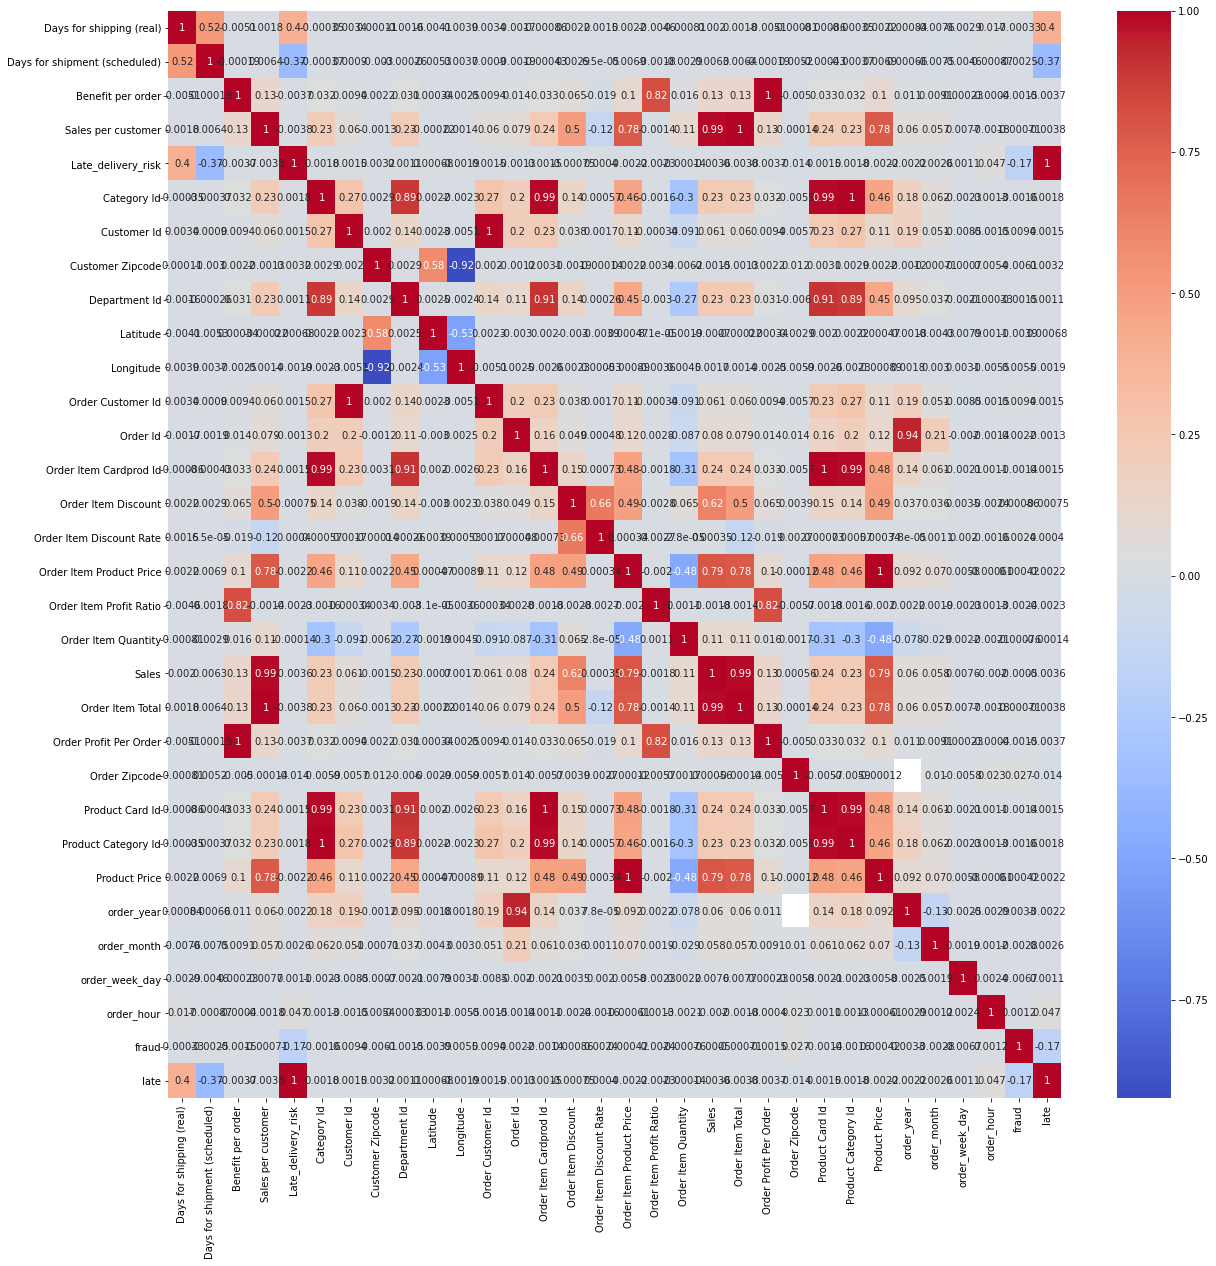

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [12]:
train_data.drop(['Order Customer Id', 'Order Item Cardprod Id', 'Order Item Total', 'Order Profit Per Order', \
           'Product Card Id', 'Product Category Id', 'Product Price', 'Sales per customer', 'Late_delivery_risk'], axis=1, inplace = True)
len(train_data.columns)

44

##### 根据特征具体含义进一步筛选

In [13]:
import pandas as pd
pd.set_option('display.max_columns', None)
train_data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Delivery Status,Category Id,Category Name,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order State,Order Status,Order Zipcode,Product Name,shipping date (DateOrders),Shipping Mode,Customer Name,order_year,order_month,order_week_day,order_hour,order_month_year,fraud,late
0,DEBIT,3,4,91.250000,Advance shipping,73,Sporting Goods,Caguas,Puerto Rico,20755,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,2018-01-31 22:56:00,77202,13.110000,0.04,327.750000,0.29,1,327.750000,Southeast Asia,Java Occidental,COMPLETE,NaN,Smart watch,2/3/2018 22:56,Standard Class,Cally Holloway,2018,1,2,22,2018-01,0,0
1,TRANSFER,5,4,-249.089996,Late delivery,73,Sporting Goods,Caguas,Puerto Rico,19492,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,2018-01-13 12:27:00,75939,16.389999,0.05,327.750000,-0.80,1,327.750000,South Asia,Rajastán,PENDING,NaN,Smart watch,1/18/2018 12:27,Standard Class,Irene Luna,2018,1,5,12,2018-01,0,1
2,CASH,4,4,-247.779999,Shipping on time,73,Sporting Goods,San Jose,EE. UU.,19491,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,2018-01-13 12:06:00,75938,18.030001,0.06,327.750000,-0.80,1,327.750000,South Asia,Rajastán,CLOSED,NaN,Smart watch,1/17/2018 12:06,Standard Class,Gillian Maldonado,2018,1,5,12,2018-01,0,0
3,DEBIT,3,4,22.860001,Advance shipping,73,Sporting Goods,Los Angeles,EE. UU.,19490,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,2018-01-13 11:45:00,75937,22.940001,0.07,327.750000,0.08,1,327.750000,Oceania,Queensland,COMPLETE,NaN,Smart watch,1/16/2018 11:45,Standard Class,Tana Tate,2018,1,5,11,2018-01,0,0
4,PAYMENT,2,4,134.210007,Advance shipping,73,Sporting Goods,Caguas,Puerto Rico,19489,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,2018-01-13 11:24:00,75936,29.500000,0.09,327.750000,0.45,1,327.750000,Oceania,Queensland,PENDING_PAYMENT,NaN,Smart watch,1/15/2018 11:24,Standard Class,Orli Hendricks,2018,1,5,11,2018-01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,Shipping on time,45,Fishing,Brooklyn,EE. UU.,1005,Home Office,NY,1322 Broad Glade,11207.0,7,Fan Shop,40.640930,-73.942711,Pacific Asia,Shanghái,China,2016-01-16 03:40:00,26043,0.000000,0.00,399.980011,0.10,1,399.980011,Eastern Asia,Shanghái,CLOSED,NaN,Field & Stream Sportsman 16 Gun Fire Safe,1/20/2016 3:40,Standard Class,Maria Peterson,2016,1,5,3,2016-01,0,0
180515,DEBIT,3,2,-613.770019,Late delivery,45,Fishing,Bakersfield,EE. UU.,9141,Corporate,CA,7330 Broad Apple Moor,93304.0,7,Fan Shop,35.362545,-119.018700,Pacific Asia,Hirakata,Japón,2016-01-16 01:34:00,26037,4.000000,0.01,399.980011,-1.55,1,399.980011,Eastern Asia,Osaka,COMPLETE,NaN,Field & Stream Sportsman 16 Gun Fire Safe,1/19/2016 1:34,Second Class,Ronald Clark,2016,1,5,1,2016-01,0,1
180516,TRANSFER,5,4,141.110001,Late delivery,45,Fishing,Bristol,EE. UU.,291,Corporate,CT,97 Burning Landing,6010.0,7,Fan Shop,41.629959,-72.967155,Pacific Asia,Adelaide,Australia,2016-01-15 21:00:00,26024,8.000000,0.02,399.980011,0.36,1,399.980011,Oceania,Australia del Sur,PENDING,NaN,Field & Stream Sportsman 16 Gun Fire Safe,1/20/2016 21:00,Standard Class,John Smith,2016,1,4,21,2016-01,0,1
180517,PAYMENT,3,4,186.229996,Advance shipping,45,Fishing,Caguas,Puerto Rico,2813,Consumer,PR,2585 Silent Autumn Landing,725.0,7

In [14]:
train_data.isnull().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Delivery Status                       0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Id                           0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      0
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0
Order City                            0
Order Country                         0
order date (DateOrders)               0
Order Id                              0
Order Item Discount                   0
Order Item Discount Rate              0


In [15]:
# Order Zipcode缺失较多，选择去掉
# 由于已经提取过年月日，可去掉order原始时间字段，而shipping date已经在Days for shipping中反映，同样可以去掉
# 由于有地区信息，经纬度、街道等过于细节的内容意义不大，可以去掉
# department name和department id重复去掉department name
train_data.drop(['Order Zipcode', 'order date (DateOrders)', 'shipping date (DateOrders)', 'order_month_year', 'Latitude', 'Longitude', 'Customer Street', 'Department Name'], axis=1, inplace = True)
len(train_data.columns)

36

In [16]:
# 可根据与预测目标之间相关性进一步精简特征
# train_data.corr()['fraud']

#### 数据预处理

In [17]:
# 查看分类类型
cat_cols = train_data.select_dtypes(include='object').columns
cat_cols

Index(['Type', 'Delivery Status', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State', 'Market',
       'Order City', 'Order Country', 'Order Region', 'Order State',
       'Order Status', 'Product Name', 'Shipping Mode', 'Customer Name'],
      dtype='object')

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for cat in cat_cols:
    train_data[cat] = le.fit_transform(train_data[cat])
train_data[cat_cols]

,Type,Delivery Status,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Market,Order City,Order Country,Order Region,Order State,Order Status,Product Name,Shipping Mode,Customer Name
0,1,0,40,66,1,0,36,3,331,70,15,475,2,78,3,1876
1,3,1,40,66,1,0,36,3,391,69,13,841,5,78,3,5378
2,0,3,40,452,0,0,5,3,391,69,13,841,1,78,3,4429
3,1,0,40,285,0,2,5,3,3226,8,11,835,2,78,3,12929
4,2,0,40,66,1,1,36,3,3226,8,11,835,6,78,3,10638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,0,3,18,59,0,2,31,3,2922,31,7,913,1,24,3,8426
180515,1,1,18,26,0,1,5,3,1362,77,7,770,2,24,2,11679
180516,3,1,18,55,0,1,7,3,25,8,11,88,5,24,3,6300
180517,2,0,18,66,1,0,36,3,25,8,11,88,6,24,3,9384


In [19]:
# 去掉可能导致标签泄露的字段
f_x = train_data.drop(['fraud', 'Order Status'], axis=1)
f_y = train_data['fraud']
l_x = train_data.drop(['late', 'Delivery Status', 'Days for shipping (real)'], axis=1) # 谨防标签泄露
l_y = train_data['late']
s_x = train_data.drop(['Sales', 'Order Item Product Price'], axis=1)
s_y = train_data['Sales']
q_x = train_data.drop(['Order Item Quantity', 'Order Item Product Price', 'Sales', 'Benefit per order'], axis=1)
q_y = train_data['Order Item Quantity']

In [20]:
# 数据集切分
from sklearn.model_selection import train_test_split
f_x_train, f_x_test, f_y_train, f_y_test = train_test_split(f_x, f_y, test_size=0.2)
l_x_train, l_x_test, l_y_train, l_y_test = train_test_split(l_x, l_y, test_size=0.2)
s_x_train, s_x_test, s_y_train, s_y_test = train_test_split(s_x, s_y, test_size=0.2)
q_x_train, q_x_test, q_y_train, q_y_test = train_test_split(q_x, q_y, test_size=0.2)

In [21]:
from sklearn.preprocessing import StandardScaler
# 数据规范化
ss = StandardScaler()
f_x_train = ss.fit_transform(f_x_train)
f_x_test = ss.transform(f_x_test)

l_x_train = ss.fit_transform(l_x_train)
l_x_test = ss.transform(l_x_test)

s_x_train = ss.fit_transform(s_x_train)
s_x_test = ss.transform(s_x_test)

q_x_train = ss.fit_transform(q_x_train)
q_x_test = ss.transform(q_x_test)

#### 分类任务

In [78]:
from collections import defaultdict
result = defaultdict(dict)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
def c_model_stats(model, x_train, y_train, x_test, y_test, model_name, name='Fraud'):
    import time
    start = time.time()
    model = model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    auc = roc_auc_score(y_pred, y_test)
    confusion = confusion_matrix(y_pred, y_test)
    t = time.time() - start
    result[name][model_name] = [accuracy, precision, recall, f1, auc, t]
    print('Mission:', name)
    print('Model:', model)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('AUC:', auc)
    print('Confusion_matrix', confusion)
    print('time', t)
#     return accuracy, recall, f1
    return model

##### KNN

In [24]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

f_knn = f_model = KNeighborsClassifier()
l_knn = l_model = KNeighborsClassifier()

f_model = c_model_stats(f_model, f_x_train, f_y_train, f_x_test, f_y_test, 'KNN')
l_model = c_model_stats(l_model, l_x_train, l_y_train, l_x_test, l_y_test, 'KNN', name = 'Late Delivery')

Mission: Fraud
Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Accuracy: 0.9809439397296699
Precision: 0.2318840579710145
Recall: 0.7868852459016393
F1: 0.35820895522388063
AUC: 0.8845748036535526
Confusion_matrix [[35224   636]
 [   52   192]]
time 1055.511653661728
Mission: Late Delivery
Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Accuracy: 0.7024706403722579
Precision: 0.7255646713258381
Recall: 0.7291094147582697
F1: 0.7273327241344298
AUC: 0.6998835028088176
Confusion_matrix [[11035  5419]
 [ 5323 14327]]
time 899.197740316391


##### 逻辑回归

In [81]:
# 逻辑回归模型
from sklearn.linear_model import LogisticRegression

f_lr = f_model = LogisticRegression()
l_lr = l_model = LogisticRegression()

f_model = c_model_stats(f_model, f_x_train, f_y_train, f_x_test, f_y_test, 'LR')
l_model = c_model_stats(l_model, l_x_train, l_y_train, l_x_test, l_y_test, 'LR', name = 'Late Delivery')

Mission: Fraud
Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.9775648127631288
Precision: 0.21859903381642512
Recall: 0.5261627906976745
F1: 0.3088737201365188
AUC: 0.7540349747671817
Confusion_matrix [[35113   647]
 [  163   181]]
time 2.6962499618530273
Mission: Late Delivery
Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.6882616884555728
Precision: 0.6258989162361998
Recall: 0.7616318481543107
F1: 

##### 朴素贝叶斯

In [83]:
# 高斯朴素贝叶斯
from sklearn.naive_bayes import GaussianNB

f_nb = f_model = GaussianNB()
l_nb = l_model = GaussianNB()

f_model = c_model_stats(f_model, f_x_train, f_y_train, f_x_test, f_y_test, 'GaussianNB')
l_model = c_model_stats(l_model, l_x_train, l_y_train, l_x_test, l_y_test, 'GaussianNB', name = 'Late Delivery')

Mission: Fraud
Model: GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy: 0.9800576113450034
Precision: 1.0
Recall: 0.5348837209302325
F1: 0.6969696969696969
AUC: 0.7674418604651163
Confusion_matrix [[34556     0]
 [  720   828]]
time 0.2069709300994873
Mission: Late Delivery
Model: GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy: 0.5701584311987591
Precision: 1.0
Recall: 0.5599319438536793
F1: 0.7178927850793477
AUC: 0.7799659719268397
Confusion_matrix [[  839     0]
 [15519 19746]]
time 0.18961524963378906


##### 决策树

In [85]:
# 决策树模型
from sklearn.tree import DecisionTreeClassifier

f_dt = f_model = DecisionTreeClassifier()
l_dr = l_model = DecisionTreeClassifier()

f_model = c_model_stats(f_model, f_x_train, f_y_train, f_x_test, f_y_test, 'DecisionTree')
l_model = c_model_stats(l_model, l_x_train, l_y_train, l_x_test, l_y_test, 'DecisionTree', name = 'Late Delivery')

Mission: Fraud
Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy: 0.9939895856414802
Precision: 0.8780193236714976
Recall: 0.8623962040332147
F1: 0.8701376421304607
AUC: 0.9297659248236746
Confusion_matrix [[35160   101]
 [  116   727]]
time 0.5050342082977295
Mission: Late Delivery
Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       

In [90]:
# 以欺诈预测为例，进行分析

#特征重要性的可视化呈现
important_col = f_dt.feature_importances_.argsort()
print(important_col)
feat_importance = pd.DataFrame({'feature':f_x.columns[important_col], 'importance':f_dt.feature_importances_[important_col]})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
feat_importance.head()

[ 0 33  8 22  6 13 29 23 26  5 19 20 27 18  2 14 21 10  3 30  1 16 31 11
 12 24  7 17 32 15 25 28  9  4]


,feature,importance
33,Delivery Status,0.510139
32,Customer Id,0.050820
31,Customer Name,0.047600
30,Order State,0.043751
29,Order City,0.037589


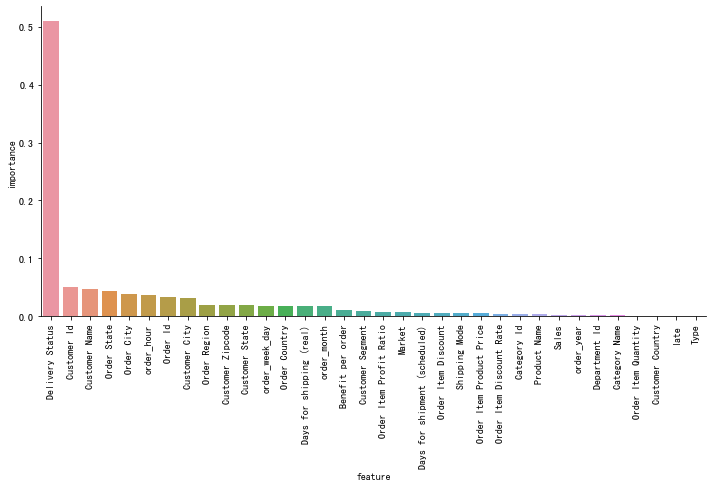

In [99]:
import seaborn as sns
sns.catplot(x='feature', y='importance', data=feat_importance, kind='bar', height=5, aspect=2) #aspect:横纵比
plt.xticks(rotation=90)
plt.show()

In [104]:
# 进一步查看重要程度最高的特征Delivery Status

# 查看不同Delivery Status中的欺诈情况
train_data[train_data['Delivery Status'] == 0]['fraud'].value_counts()

0    41592
Name: fraud, dtype: int64

In [101]:
train_data[train_data['Delivery Status'] == 1]['fraud'].value_counts()

0    98977
Name: fraud, dtype: int64

In [102]:
train_data['Delivery Status'].value_counts()

1    98977
0    41592
3    32196
2     7754
Name: Delivery Status, dtype: int64

In [103]:
data['Delivery Status'].value_counts()

Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled     7754
Name: Delivery Status, dtype: int64

上述结果表明Delivery Status对欺诈情况有较明显的区分度，这可能是其重要性较高的原因，从可解释性上来看，提前运送或者迟送的订单大概率都不是欺诈订单，可能是因为提前送达使得用户很难实施欺诈，而迟送却没有被取消可能说明用户对商品本身有一定的执着性，用户抱有欺诈意图的概率更小。

##### 随机森林

In [108]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier

f_rf = f_model = RandomForestClassifier()
l_rf = l_model = RandomForestClassifier()

f_model = c_model_stats(f_model, f_x_train, f_y_train, f_x_test, f_y_test,'RandomForest')
l_model = c_model_stats(l_model, l_x_train, l_y_train, l_x_test, l_y_test, 'RandomForest', name = 'Late Delivery')

Mission: Fraud
Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy: 0.9957068468867716
Precision: 0.8635265700483091
Recall: 0.9445178335535006
F1: 0.9022082018927444
AUC: 0.970660478436863
Confusion_matrix [[35234   113]
 [   42   715]]
time 14.156899690628052
Mission: Late Delivery
Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, ma

#####  结果汇总

In [129]:
f_result = result['Fraud']
l_result = result['Late Delivery']

In [137]:
print('对于欺诈预测:')
pd.DataFrame(f_result, index=['accuracy', 'precision', 'recall', 'f1', 'auc', 'time'])

对于欺诈预测:


,KNN,LR,GaussianNB,DecisionTree,RandomForest
accuracy,0.980944,0.977565,0.980058,0.993990,0.995707
precision,0.231884,0.218599,1.000000,0.878019,0.863527
recall,0.786885,0.526163,0.534884,0.862396,0.944518
f1,0.358209,0.308874,0.696970,0.870138,0.902208
auc,0.884575,0.754035,0.767442,0.929766,0.970660
time,1055.511654,2.696250,0.206971,0.505034,14.156900


In [138]:
print('对于迟送订单预测:')
pd.DataFrame(l_result, index=['accuracy', 'precision', 'recall', 'f1', 'auc', 'time'])

对于迟送订单预测:


,KNN,LR,GaussianNB,DecisionTree,RandomForest
accuracy,0.702471,0.688262,0.570158,0.910093,0.881121
precision,0.725565,0.625899,1.000000,0.916844,0.837081
recall,0.729109,0.761632,0.559932,0.918612,0.938934
f1,0.727333,0.687126,0.717893,0.917727,0.885087
auc,0.699884,0.694998,0.779966,0.909233,0.882521
time,899.197740,1.768119,0.189615,4.934533,67.477029


##### 模型融合

In [126]:
# 以欺诈预测为例，利用决策树和高斯贝叶斯进行模型融合
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate


voting = VotingClassifier(estimators={('DT', f_dt), ('GaussianNB', f_nb)}, voting='soft')
for clf, label in zip([f_dt, f_rf, voting], ['DesicionTree', 'GaussianNB', 'Voting']):
    scores = cross_validate(clf, f_x, f_y, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    print('Model: %s, Accuracy: %0.2f, Precision: %0.2f, Recall: %0.2f, F1: %0.2f, AUC: %0.2f' %\
          (label, scores['test_accuracy'].mean(), scores['test_precision'].mean(), scores['test_recall'].mean(),\
          scores['test_f1'].mean(), scores['test_roc_auc'].mean()))

Model: DesicionTree, Accuracy: 0.98, Precision: 0.60, Recall: 0.55, F1: 0.54, AUC: 0.77
Model: GaussianNB, Accuracy: 0.98, Precision: 0.59, Recall: 0.48, F1: 0.46, AUC: 0.99
Model: Voting, Accuracy: 0.98, Precision: 0.60, Recall: 0.55, F1: 0.54, AUC: 0.97


##### 神经网络

In [41]:
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision

def network(x_train, y_train, epoch=5, name='Fraud'):
    print('Mission:', name)
    keras.layers.BatchNormalization() # BatchNormalization()input的标准化
    clf = Sequential()
    clf.add(Dense(512, activation='relu', input_dim = x_train.shape[1], kernel_initializer='random_normal')) # kernel_initializer是针对参数的初始化
    clf.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
    clf.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
    clf.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    # 定义优化器，损失函数
    clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    clf.fit(x_train, y_train, batch_size=512, epochs=epoch)
    return clf

In [43]:
f_net = network(f_x,f_y)
l_net = network(l_x,l_y, name='Late Delivery')

Mission: Fraud
Epoch 1/5
353/353 [==============================] - 15s 41ms/step - loss: 27.5162 - accuracy: 0.9507 - precision: 0.0196 - recall: 0.0244
Epoch 2/5
353/353 [==============================] - 15s 44ms/step - loss: 1.2932 - accuracy: 0.9584 - precision: 0.0200 - recall: 0.0177
Epoch 3/5
353/353 [==============================] - 12s 34ms/step - loss: 0.4889 - accuracy: 0.9640 - precision: 0.0280 - recall: 0.0177
Epoch 4/5
353/353 [==============================] - 11s 30ms/step - loss: 0.1648 - accuracy: 0.9757 - precision: 0.0620 - recall: 0.0057
Epoch 5/5
353/353 [==============================] - 12s 33ms/step - loss: 0.1643 - accuracy: 0.9758 - precision: 0.0564 - recall: 0.0047
Mission: Late Delivery
Epoch 1/5
353/353 [==============================] - 16s 44ms/step - loss: 20.8409 - accuracy: 0.5063 - precision: 0.5494 - recall: 0.5529
Epoch 2/5
353/353 [==============================] - 17s 48ms/step - loss: 1.1604 - accuracy: 0.5125 - precision: 0.5535 - recall: 0

In [44]:
f_evaluate = f_net.evaluate(f_x_test, f_y_test)
l_evaluate = l_net.evaluate(l_x_test, l_y_test)

1129/1129 [==============================] - 10s 9ms/step - loss: 0.6933 - accuracy: 0.5647 - precision: 0.6047 - recall: 0.5894


#### 回归任务

In [49]:
from collections import defaultdict
result = defaultdict(dict)

from sklearn.metrics import mean_absolute_error, mean_squared_error
def r_model_stats(model, x_train, y_train, x_test, y_test, model_name, name='Sales'):
    import time
    start = time.time()
    model = model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_pred, y_test)
    mse = mean_squared_error(y_pred, y_test)
    t = time.time() - start
    result[name][model_name] = [mae, mse, t]
    print('Mission:', name)
    print('Model:', model)
    print('MAE:', mae)
    print('MSE:', mse)
    print('time:', t)
#     return mae, mse
    return model

##### 线性判别分析

In [50]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

s_lda = s_model = LinearDiscriminantAnalysis()
q_lda = q_model = LinearDiscriminantAnalysis()

s_model = r_model_stats(s_model, s_x_train, s_y_train.astype('int'), s_x_test, s_y_test.astype('int'), 'LDA')
q_model = r_model_stats(q_model, q_x_train, q_y_train, q_x_test, q_y_test, 'LDA', name='Quantity')

Mission: Sales
Model: LinearDiscriminantAnalysis()
MAE: 20.25501329492577
MSE: 3503.666214269887
time: 0.6941404342651367
Mission: Quantity
Model: LinearDiscriminantAnalysis()
MAE: 0.9498670507423
MSE: 2.6477398626191
time: 0.610365629196167


##### 岭回归

In [51]:
from sklearn.linear_model import Ridge

s_lr = s_model = Ridge()
s_lr = q_model = Ridge()

s_model = r_model_stats(s_model, s_x_train, s_y_train, s_x_test, s_y_test, 'Ridge')
q_model = r_model_stats(q_model, q_x_train, q_y_train, q_x_test, q_y_test, 'Ridge', name='Quantity')

Mission: Sales
Model: Ridge()
MAE: 43.75411189008193
MSE: 4807.171927114234
time: 0.04986763000488281
Mission: Quantity
Model: Ridge()
MAE: 1.0475145557358028
MSE: 1.6186641441017928
time: 0.04339098930358887


##### 决策树

In [52]:
# 决策树
from sklearn.tree import DecisionTreeRegressor

s_dt = s_model = DecisionTreeRegressor()
s_dt = q_model = DecisionTreeRegressor()

s_model = r_model_stats(s_model, s_x_train, s_y_train, s_x_test, s_y_test, 'DecisionTree')
q_model = r_model_stats(q_model, q_x_train, q_y_train, q_x_test, q_y_test, 'DecisionTree', name='Quantity')

Mission: Sales
Model: DecisionTreeRegressor()
MAE: 0.15701224486269064
MSE: 40.072161599404005
time: 1.7572650909423828
Mission: Quantity
Model: DecisionTreeRegressor()
MAE: 0.07054619986705074
MSE: 0.1656049191225349
time: 1.303495168685913


##### XGBoost

In [53]:
# xgboost
import xgboost as xgb

s_xgb = s_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7)
q_xgb = q_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7)

s_model = r_model_stats(s_model, s_x_train, s_y_train, s_x_test, s_y_test, 'XGBoost')
q_model = r_model_stats(q_model, q_x_train, q_y_train, q_x_test, q_y_test, 'XGBoost', name='Quantity')

Mission: Sales
Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
MAE: 0.9109651513862541
MSE: 34.38786042848801
time: 25.482244729995728
Mission: Quantity
Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, 

In [25]:
# 以订货数量为例，进行分析
# 特征重要性的可视化呈现
important_col = q_model.feature_importances_.argsort()
print(important_col)
feat_importance = pd.DataFrame({'feature':q_x.columns[important_col], 'importance':q_model.feature_importances_[important_col]})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
feat_importance.head()

[26 30  0  1  7  3  2 31 15  6  9 13 22 10 14 11  8 25 20 19 28 21 29 27
 24 12 16  5 17 18  4 23]


,feature,importance
31,Product Name,0.245265
30,Category Id,0.216769
29,Order Item Discount Rate,0.175130
28,Order Item Discount,0.134162
27,Category Name,0.092282


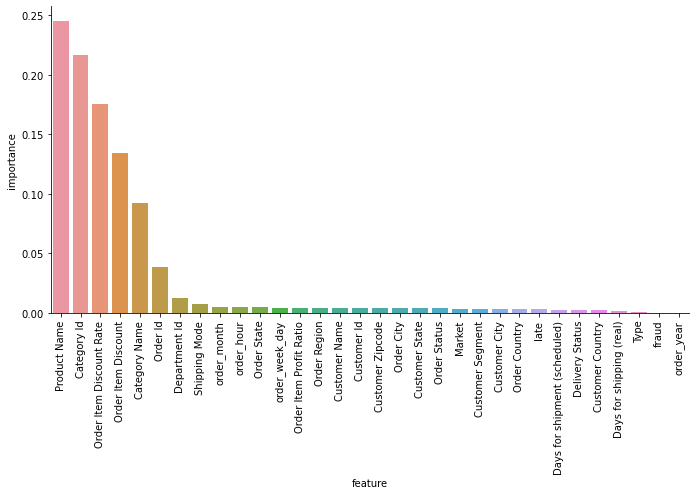

In [26]:
import seaborn as sns
sns.catplot(x='feature', y='importance', data=feat_importance, kind='bar', height=5, aspect=2) #aspect:横纵比
plt.xticks(rotation=90)
plt.show()

图中显示产品本身是什么和产品的折扣是最能影响订货数量的因素，很符合生活直观。

##### 结果汇总

In [54]:
s_result = result['Sales']
q_result = result['Quantity']

In [55]:
print('对于销售额预测:')
pd.DataFrame(s_result, index=['MAE', 'MSE', 'time'])

对于销售额预测:


,LDA,Ridge,DecisionTree,XGBoost
MAE,20.255013,43.754112,0.157012,0.910965
MSE,3503.666214,4807.171927,40.072162,34.387860
time,0.694140,0.049868,1.757265,25.482245


In [56]:
print('对于订货数量预测:')
pd.DataFrame(q_result, index=['MAE', 'MSE', 'time'])

对于订货数量预测:


,LDA,Ridge,DecisionTree,XGBoost
MAE,0.949867,1.047515,0.070546,0.071459
MSE,2.647740,1.618664,0.165605,0.074629
time,0.610366,0.043391,1.303495,23.918800


### Action2
一个农民承包了6块耕地共300亩，准备播种小麦，玉米，水果和蔬菜四种农产品，已知各种农产品的计划播种面积、每块土地种植不同农产品的单产收益
如何进行合理安排，使得总收益最大
可以使用pulp/ortools工具

In [1]:
# 每种作物在各地块上的单产收益
benefit = [[500, 550, 630, 1000, 800, 700],
[800, 700, 600, 950, 900, 930],
[1000, 960, 840, 650, 600, 700],
[1200, 1040, 980, 860, 880, 780]]

# 每种作物的种植面积
plant = [76, 88, 96, 40]

# 各地块面积
field = [42, 56, 44, 39, 60, 59]

In [55]:
import pulp

def dim2_problem(cost, x_max, y_max, name, maximize=False):
    row = len(cost) # 作物数
    col = len(cost[0]) # 土地数
#     print(row)
#     print(col)

    # 定义问题
    if maximize:
        prob = pulp.LpProblem(name, sense=pulp.LpMaximize)
    else:
        prob = pulp.LpProblem(name, sense=pulp.LpMinimize)
        
    # 定义变量
    var = [[pulp.LpVariable(f'x{i}{j}', lowBound=0) for j in range(col)] for i in range(row)]
#     print(var)
    # 将列表内的嵌套展开
    flatten = lambda x: [y for i in x for y in flatten(i)] if type(x) is list else [x]
#     print(flatten(var))

    # 定义目标函数
    prob += pulp.lpDot(flatten(var), flatten(cost))
    
    # 定义约束条件
    for i in range(row):
        prob += pulp.lpSum(var[i][j] for j in range(col)) <= x_max[i]
    for j in range(col):
        prob += pulp.lpSum(var[i][j] for i in range(row)) <= y_max[j]
    
    # 求解
    prob.solve()
#     print(prob.objective) # 直接打印prob.objective得到的是目标函数
#     print(prob.variables)
    result = {'obj': pulp.value(prob.objective), \
              'var': [[pulp.value(var[i][j]) for j in range(col)] for i in range(row)]}
    return result      

In [81]:
result = dim2_problem(benefit, plant, field, 'Farming', True)
print('最大收益为：', result['obj'])
print('每种作物在各地块上的种植面积：\n', result['var'])

最大收益为： 284230.0
每种作物在各地块上的种植面积：
 [[0.0, 0.0, 6.0, 39.0, 31.0, 0.0], [0.0, 0.0, 0.0, 0.0, 29.0, 59.0], [2.0, 56.0, 38.0, 0.0, 0.0, 0.0], [40.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
